<a href="https://colab.research.google.com/github/MarinaZRocha/Mod_Ling_Robotica/blob/main/MIGC_ONLINE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Experience the capabilities of MIGC, the Multi-Instance Generation Controller for Text-to-Image Synthesis (CVPR2024), directly in your browser. MIGC allows for controlled and customizable image generation based on textual descriptions. If you find our project useful, please consider giving us a star ⭐️ on GitHub. https://github.com/limuloo/MIGC**

# **Install dependencies**

In [1]:
# install environment
# ❗🔔🚨 After installing the environment
# ❗🔔🚨 colab will ask to restart.
# ❗🔔🚨 Please restart and then execute the following cell.
# ❗🔔🚨 Please make sure that the environment has been installed before executing the following cell, otherwise errors may occur!
# !pip install --upgrade --no-cache-dir gdown
# !pip install transformers
# !pip install torch
# !pip install accelerate
# !pip install flask
# !pip install pyngrok
# !pip install opencv-python
# !pip install einops
# !pip install diffusers==0.25.0
# !pip install omegaconf
!pip install gdown==5.2.0
!pip install transformers==4.48.3
!pip install torch==2.5.1 torchvision==0.20.1 torchaudio==2.5.1 --index-url https://download.pytorch.org/whl/cu124
!pip install accelerate==1.3.0
!pip install flask==3.1.0
!pip install pyngrok==7.2.3
!pip install opencv-python==4.11.0.86
!pip install einops==0.8.1
!pip install diffusers==0.25.0
!pip install omegaconf==2.3.0

Looking in indexes: https://download.pytorch.org/whl/cu124


In [2]:
# clone MIGC project. If you think this project is meaningful and helpful to you, please give us a star⭐️. We will be grateful.
!git clone https://github.com/limuloo/MIGC.git
%cd MIGC

fatal: destination path 'MIGC' already exists and is not an empty directory.
/content/MIGC


In [3]:
!pwd

/content/MIGC


In [4]:
!pip install -e .

Obtaining file:///content/MIGC
  Preparing metadata (setup.py) ... done
  Attempting uninstall: MIGC
    Found existing installation: MIGC 0.1
    Uninstalling MIGC-0.1:
      Successfully uninstalled MIGC-0.1
  Running setup.py develop for MIGC


In [5]:
!gdown --id 1v5ik-94qlfKuCx-Cv1EfEkxNBygtsz0T -O ./pretrained_weights/MIGC_SD14.ckpt
!gdown --id 1cmdif24erg3Pph3zIZaUoaSzqVEuEfYM -O ./migc_gui_weights/sd/cetusMix_Whalefall2.safetensors
!gdown --id 1Z_BFepTXMbe-cib7Lla5A224XXE1mBcS -O ./migc_gui_weights/clip/text_encoder/pytorch_model.bin

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1v5ik-94qlfKuCx-Cv1EfEkxNBygtsz0T
From (redirected): https://drive.google.com/uc?id=1v5ik-94qlfKuCx-Cv1EfEkxNBygtsz0T&confirm=t&uuid=96130249-d382-4ba4-aab0-79aa76e8097b
To: /content/MIGC/pretrained_weights/MIGC_SD14.ckpt
100% 230M/230M [00:01<00:00, 132MB/s]
/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1cmdif24erg3Pph3zIZaUoaSzqVEuEfYM
From (redirected): https://drive.google.com/uc?id=1cmdif24erg3Pph3zIZaUoaSzqVEuEfYM&confirm=t&uuid=75de98e4-fec5-41eb-8f92-141ca393f2d5
To

# **Construct StableDiffusionMIGCPipeline**

In [6]:
!pip install huggingface-hub==0.25.2

In [7]:
import argparse
import numpy as np
import torch
import os
import yaml
import random
from diffusers.utils.import_utils import is_accelerate_available
from transformers import CLIPTextModel, CLIPTokenizer
from migc.migc_pipeline import StableDiffusionMIGCPipeline, MIGCProcessor, AttentionStore
from diffusers import EulerDiscreteScheduler
if is_accelerate_available():
    from accelerate import init_empty_weights
from contextlib import nullcontext

def offlinePipelineSetupWithSafeTensor(sd_safetensors_path):
    migc_ckpt_path = '/content/MIGC/pretrained_weights/MIGC_SD14.ckpt'
    clip_model_path = '/content/MIGC/migc_gui_weights/clip/text_encoder'
    clip_tokenizer_path = '/content/MIGC/migc_gui_weights/clip/tokenizer'
    original_config_file='/content/MIGC/migc_gui_weights/v1-inference.yaml'
    ctx = init_empty_weights if is_accelerate_available() else nullcontext
    with ctx():
        # text_encoder = CLIPTextModel(config)
        text_encoder = CLIPTextModel.from_pretrained(clip_model_path)
        tokenizer = CLIPTokenizer.from_pretrained(clip_tokenizer_path)
    pipe = StableDiffusionMIGCPipeline.from_single_file(sd_safetensors_path,
                                                    original_config_file=original_config_file,
                                                    text_encoder=text_encoder,
                                                    tokenizer=tokenizer,
                                                    load_safety_checker=False)
    print('Initializing pipeline')
    pipe.attention_store = AttentionStore()
    from migc.migc_utils import load_migc
    load_migc(pipe.unet , pipe.attention_store,
            migc_ckpt_path, attn_processor=MIGCProcessor)

    pipe.scheduler = EulerDiscreteScheduler.from_config(pipe.scheduler.config)
    return pipe

/usr/local/lib/python3.12/dist-packages/diffusers/utils/outputs.py:63: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/usr/local/lib/python3.12/dist-packages/diffusers/utils/outputs.py:63: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


In [8]:
import yaml
from diffusers import EulerDiscreteScheduler
from migc.migc_utils import seed_everything
from migc.migc_pipeline import StableDiffusionMIGCPipeline, MIGCProcessor, AttentionStore
import os
from google.colab.patches import cv2_imshow, cv2

!pip install peft==0.6.2

# migc_ckpt_path = 'pretrained_weights/MIGC_SD14.ckpt'
# assert os.path.isfile(migc_ckpt_path), "Please download the ckpt of migc and put it in the pretrained_weighrs/ folder!"


pipe = offlinePipelineSetupWithSafeTensor('./migc_gui_weights/sd/cetusMix_Whalefall2.safetensors')
pipe = pipe.to("cuda")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:2400: UserWarning: for text_model.embeddings.token_embedding.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:2400: UserWarning: for text_model.embeddings.position_embedding.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:2400: UserWarning: for text_model.encoder.layers.0.self_attn.k_proj.weight: copying from a non-m

Initializing pipeline


/content/MIGC/migc/migc_utils.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(pretrained_MIGC_path, map_location="cpu")


# **Generate Image**

  0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:533: FutureWarning: The decode_latents method is deprecated and will be removed in 1.0.0. Please use VaeImageProcessor.postprocess(...) instead
  deprecate("decode_latents", "1.0.0", deprecation_message, standard_warn=False)


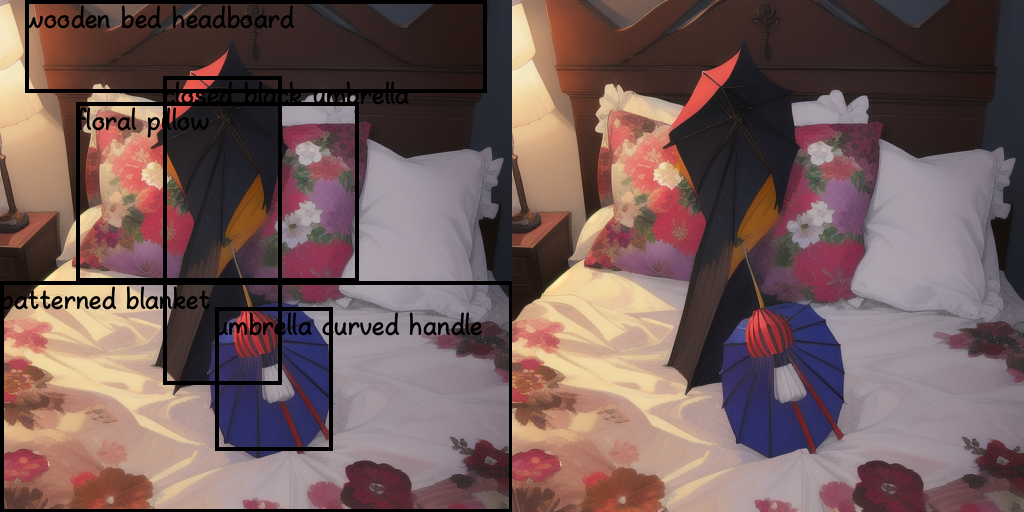

In [15]:
prompt_final = [[
    'masterpiece, best quality, closed black umbrella, curved handle umbrella, floral pillow, wooden bed headboard, patterned blanket, indoor bedroom scene, soft indoor lighting',
    'closed black umbrella',
    'umbrella curved handle',
    'floral pillow',
    'wooden bed headboard',
    'patterned blanket'
]]

bboxes = [[
    [0.32, 0.15, 0.55, 0.75],   # closed black umbrella (shaft + fabric)
    [0.42, 0.60, 0.65, 0.88],   # curved umbrella handle
    [0.15, 0.20, 0.70, 0.55],   # floral pillow
    [0.05, 0.00, 0.95, 0.18],   # wooden bed headboard
    [0.00, 0.55, 1.00, 1.00]    # patterned blanket (background)
]]

negative_prompt = 'worst quality, low quality, bad anatomy, watermark, text, blurry'
seed = 7351007268695528845
seed_everything(seed)
image = pipe(prompt_final, bboxes, num_inference_steps=30, guidance_scale=7.5,
                MIGCsteps=15, aug_phase_with_and=False, negative_prompt=negative_prompt, NaiveFuserSteps=30).images[0]
image.save('output1.png')
image.show()
image = pipe.draw_box_desc(image, bboxes[0], prompt_final[0][1:])
image.save('anno_output1.png')
image.show()


img_anno = cv2.imread('./anno_output1.png')
img = cv2.imread('./output1.png')
cv2_imshow(np.concatenate([img_anno, img], axis=1))


  0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:533: FutureWarning: The decode_latents method is deprecated and will be removed in 1.0.0. Please use VaeImageProcessor.postprocess(...) instead
  deprecate("decode_latents", "1.0.0", deprecation_message, standard_warn=False)


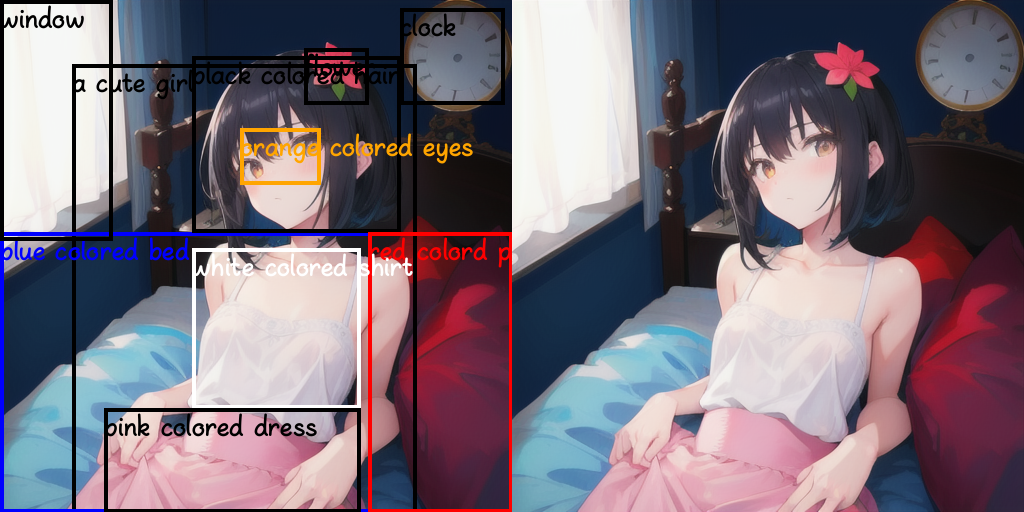

In [10]:
prompt_final = [['4k, best quality, masterpiece, ultra high res, ultra detailed,a cute girl,blue colored bed,window,\
                clock,black colored hair,orange colored eyes,red colord pillow,white colored shirt,pink colored dress,flower', \
                 'a cute girl', 'blue colored bed', 'window', 'clock', 'black colored hair', 'orange colored eyes', 'red colord pillow', \
                 'white colored shirt', 'pink colored dress', 'flower']]
bboxes = [[[0.140625, 0.125, 0.8125, 1.0], [0.0, 0.453125, 1.0, 1.0], [0.0, 0.0, 0.21875, 0.46875],
 [0.78125, 0.015625, 0.984375, 0.203125], [0.375, 0.109375, 0.78125, 0.453125], [0.46875, 0.25, 0.625, 0.359375],
  [0.71875, 0.453125, 1.0, 1.0], [0.375, 0.484375, 0.703125, 0.796875], [0.203125, 0.796875, 0.703125, 1.0], [0.59375, 0.09375, 0.71875, 0.203125]]]
negative_prompt = 'worst quality, low quality, bad anatomy, watermark, text, blurry'
seed = 4988741440008356583
seed_everything(seed)
image = pipe(prompt_final, bboxes, num_inference_steps=30, guidance_scale=8.0,
                MIGCsteps=15, aug_phase_with_and=False, negative_prompt=negative_prompt, NaiveFuserSteps=30).images[0]
image.save('output2.png')
image.show()
image = pipe.draw_box_desc(image, bboxes[0], prompt_final[0][1:])
image.save('anno_output2.png')
image.show()


img_anno = cv2.imread('./anno_output2.png')
img = cv2.imread('./output2.png')
cv2_imshow(np.concatenate([img_anno, img], axis=1))


  0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:533: FutureWarning: The decode_latents method is deprecated and will be removed in 1.0.0. Please use VaeImageProcessor.postprocess(...) instead
  deprecate("decode_latents", "1.0.0", deprecation_message, standard_warn=False)


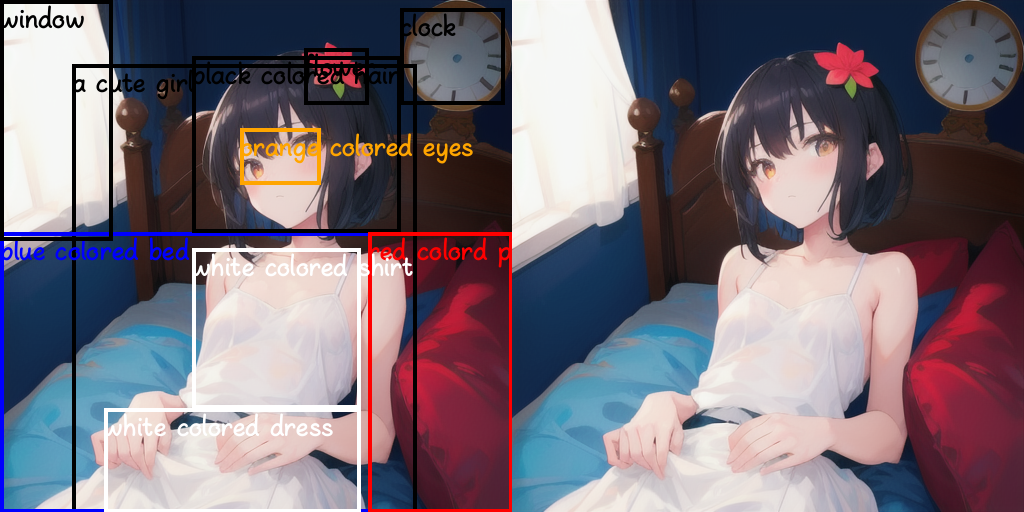

In [11]:
prompt_final = [['4k, best quality, masterpiece, ultra high res, ultra detailed,a cute girl,blue colored bed,window,\
                clock,black colored hair,orange colored eyes,red colord pillow,white colored shirt,white colored dress,flower', \
                 'a cute girl', 'blue colored bed', 'window', 'clock', 'black colored hair', 'orange colored eyes', 'red colord pillow', \
                 'white colored shirt', 'white colored dress', 'flower']]
bboxes = [[[0.140625, 0.125, 0.8125, 1.0], [0.0, 0.453125, 1.0, 1.0], [0.0, 0.0, 0.21875, 0.46875],
 [0.78125, 0.015625, 0.984375, 0.203125], [0.375, 0.109375, 0.78125, 0.453125], [0.46875, 0.25, 0.625, 0.359375],
  [0.71875, 0.453125, 1.0, 1.0], [0.375, 0.484375, 0.703125, 0.796875], [0.203125, 0.796875, 0.703125, 1.0], [0.59375, 0.09375, 0.71875, 0.203125]]]
negative_prompt = 'worst quality, low quality, bad anatomy, watermark, text, blurry'
seed = 4988741440008356583
seed_everything(seed)
image = pipe(prompt_final, bboxes, num_inference_steps=30, guidance_scale=8.0,
                MIGCsteps=15, aug_phase_with_and=False, negative_prompt=negative_prompt, NaiveFuserSteps=30).images[0]
image.save('output2.png')
image.show()
image = pipe.draw_box_desc(image, bboxes[0], prompt_final[0][1:])
image.save('anno_output2.png')
image.show()


img_anno = cv2.imread('./anno_output2.png')
img = cv2.imread('./output2.png')
cv2_imshow(np.concatenate([img_anno, img], axis=1))
